In [22]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install ftfy regex tqdm
!pip install yacs
!pip install torch transformers pytorch-lightning
!pip install --upgrade pytorch-lightning optuna optuna-integration

Looking in indexes: https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
# !pip install numba

# from numba import cuda
# device = cuda.get_current_device()
# device.reset()
import torch

print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
print("Device Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA Available: True
CUDA Device Count: 1
Current Device: 0
Device Name: NVIDIA GeForce RTX 3080 Ti


In [24]:
import os
from PIL import Image
import torch.nn as nn
import torchmetrics
from transformers import BlipProcessor, BlipForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import pandas as pd
from yacs.config import CfgNode
import numpy as np
import json

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)

In [25]:
class Custom_Dataset(Dataset):
    def __init__(self, cfg, root_folder, dataset, label, split='train', image_size=224, fast=True):
        super(Custom_Dataset, self).__init__()
        self.cfg = cfg
        self.root_folder = root_folder
        self.dataset = dataset
        self.split = split
        self.label = label

        self.image_size = image_size
        self.fast = fast

        self.info_file = cfg.info_file
        self.df = pd.read_csv(self.info_file)
        self.df = self.df[self.df['split'] == self.split].reset_index(drop=True)

        if self.label == 'target':
            self.df = self.df[self.df['hate'] == 1].reset_index(drop=True)

        float_cols = self.df.select_dtypes(float).columns
        self.df[float_cols] = self.df[float_cols].fillna(-1).astype('Int64')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        if row['text'] == 'None':
            text = 'null'
        else:
            text = row['text']

        image_fn = row['name']
        try:
            image = Image.open(f"{self.cfg.img_folder}/{image_fn}").convert('RGB')
            image = image.resize((self.image_size, self.image_size))
        except Exception as e:
            raise ValueError(f"Error loading image {image_fn}: {e}")

        item = {
        'image': image,
        'text': text,
        'label': row[self.label],
        'idx_meme': row['name'],
        }
        return item

In [26]:
from Dataset import HatefulMemesDataset

In [27]:
from transformers import BlipProcessor, BlipForImageTextRetrieval, BlipConfig

class MemeBLIP_Collator:
    def __init__(self, cfg):
        self.cfg = cfg
        # Modify configuration
        blipconfig = BlipConfig.from_pretrained("Salesforce/blip-itm-large-coco")
        blipconfig.max_position_embeddings = 2048  # Extend max length if needed
        # Initialize BLIP model and processor
        self.processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-large-coco")
        self.blip_model = BlipForImageTextRetrieval.from_pretrained(
            "Salesforce/blip-itm-large-coco", config=blipconfig
        ).to(self.cfg.device)
        self.blip_model.eval()

    def split_text_into_chunks(self, text, max_length):
        """
        Splits a long text into chunks of size `max_length`.
        """
        tokens = self.processor.tokenizer(
            text, return_tensors="pt", truncation=False, add_special_tokens=False
        )["input_ids"].squeeze(0).tolist()
        return [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]

    def __call__(self, batch):
        # Prepare feature lists
        image_features_list = []
        text_features_list = []

        labels = torch.LongTensor([item['label'] for item in batch]).to(self.cfg.device)
        idx_memes = [item['idx_meme'] for item in batch]

        batch_new = {
            'labels': labels,
            'idx_memes': idx_memes,
        }

        for item in batch:
            # Process image
            processed_image = self.processor(
                images=item['image'], return_tensors="pt"
            )["pixel_values"].to(self.cfg.device)

            # Process text: Split into chunks
            text_chunks = self.split_text_into_chunks(item['text'], 512)
            text_features = []

            for chunk in text_chunks:
                processed_text = {
                    "input_ids": torch.tensor([chunk]).to(self.cfg.device),
                    "attention_mask": torch.ones(len(chunk)).unsqueeze(0).to(self.cfg.device)
                }

                # Extract features for each chunk
                _, chunk_features = self.compute_features(
                    {"pixel_values": processed_image, **processed_text}
                )
                text_features.append(chunk_features)

            # Aggregate features from chunks
            text_features = torch.mean(torch.stack(text_features), dim=0)

            # Extract image features
            image_features, _ = self.compute_features(
                {"pixel_values": processed_image, **processed_text}
            )

            # Collect features
            image_features_list.append(image_features.cpu().detach())
            text_features_list.append(text_features.cpu().detach())

        # Combine features
        batch_new['image_features'] = torch.cat(image_features_list, dim=0).to(self.cfg.device)
        batch_new['text_features'] = torch.cat(text_features_list, dim=0).to(self.cfg.device)

        return batch_new

    def compute_features(self, processed):
        # Extract visual and text features from BLIP model
        vision_output = self.blip_model.vision_model(processed['pixel_values'])
        image_features = vision_output.pooler_output.to(self.cfg.device)  # Image features
        text_output = self.blip_model.text_encoder(
            input_ids=processed['input_ids'],
            attention_mask=processed['attention_mask']
        )
        text_features = text_output.last_hidden_state.mean(dim=1).to(self.cfg.device)  # Text features

        return image_features, text_features


In [28]:
def load_dataset(cfg, split="train"):
    dataset = HatefulMemesDataset(cfg, split="train")
    # 统计数据集中 0 和 1 的数量
    labels = [item["label"] for item in dataset.entries if "label" in item]
    print("标签分布:", {0: labels.count(0), 1: labels.count(1)})

    return dataset


In [29]:
def create_dataloader(cfg, split="dev"):
    print("start loading dataset")
    dataset = load_dataset(cfg, split="train")
    subset_size = int(len(dataset) * 0.5)  # 使用 30% 的数据
    subset_indices = np.random.choice(len(dataset), subset_size, replace=False)

    # 创建子集
    subset = Subset(dataset, subset_indices)
    collator = MemeBLIP_Collator(cfg)
    generator = torch.Generator(device="cuda") if torch.cuda.is_available() else torch.Generator()

    print("start creating dataloader")
    dataloader = DataLoader(
        subset,
        batch_size=cfg.batch_size,
        shuffle= False,
        generator = generator,
        collate_fn=collator
    )
    print("finished creating dataloader")
    return dataloader

In [30]:
cfg = CfgNode()

# 路径设置
cfg.root_dir = 'memeblip'
cfg.img_folder = 'memeblip/Facebook_HarmMeme/img'
# cfg.info_file = 'memeblip/Facebook HarmMeme/PrideMM.csv'
cfg.train_jsonl = 'memeblip/Facebook_HarmMeme/train.jsonl'
cfg.dev_jsonl = 'memeblip/Facebook_HarmMeme/dev.jsonl'
cfg.checkpoint_path = os.path.join(cfg.root_dir, 'checkpoints')
cfg.checkpoint_file = os.path.join(cfg.checkpoint_path, 'model.ckpt')

# 模型与数据集设置
cfg.clip_variant = "ViT-L/14"
cfg.dataset_name = 'HatefulMemes'
cfg.name = 'MemeBLIP'
cfg.label = 'hate'
cfg.seed = 42
cfg.test_only = False
cfg.device = 'cuda'
cfg.gpus = [0]

# 根据任务类型动态设置类别
# if cfg.label == 'hate':
#     cfg.class_names = ['Benign Meme', 'Harmful Meme']
# elif cfg.label == 'humour':
#     cfg.class_names = ['No Humour', 'Humour']
# elif cfg.label == 'target':
#     cfg.class_names = ['No particular target', 'Individual', 'Community', 'Organization']
# elif cfg.label == 'stance':
#     cfg.class_names = ['Neutral', 'Support', 'Oppose']
cfg.class_names = ["Not Hateful", "Hateful"]

# 超参数设置
cfg.batch_size = 32
cfg.image_size = 224
cfg.num_mapping_layers = 1
cfg.unmapped_dim = 768
cfg.map_dim = 1024
cfg.num_pre_output_layers = 2
cfg.drop_probs = [0.4, 0.2, 0.3]
cfg.dropout_rate = 0.5
cfg.hidden_dim = 1024
cfg.lr = 1e-4
cfg.max_epochs = 20
cfg.weight_decay = 1e-4
cfg.num_classes = len(cfg.class_names)
cfg.scale = 30
cfg.print_model = True
cfg.fast_process = True
cfg.reproduce = False
cfg.ratio = 0.5
cfg.num_layers = 3
cfg.activation = 'ReLU'
cfg.hidden_dim1 = 1024

print(cfg)


activation: ReLU
batch_size: 32
checkpoint_file: memeblip\checkpoints\model.ckpt
checkpoint_path: memeblip\checkpoints
class_names: ['Not Hateful', 'Hateful']
clip_variant: ViT-L/14
dataset_name: HatefulMemes
dev_jsonl: memeblip/Facebook_HarmMeme/dev.jsonl
device: cuda
drop_probs: [0.4, 0.2, 0.3]
dropout_rate: 0.5
fast_process: True
gpus: [0]
hidden_dim: 1024
hidden_dim1: 1024
image_size: 224
img_folder: memeblip/Facebook_HarmMeme/img
label: hate
lr: 0.0001
map_dim: 1024
max_epochs: 20
name: MemeBLIP
num_classes: 2
num_layers: 3
num_mapping_layers: 1
num_pre_output_layers: 2
print_model: True
ratio: 0.5
reproduce: False
root_dir: memeblip
scale: 30
seed: 42
test_only: False
train_jsonl: memeblip/Facebook_HarmMeme/train.jsonl
unmapped_dim: 768
weight_decay: 0.0001


In [31]:
from torch.utils.data import Subset
import os
print(os.getcwd())
data_file = "memeblip/PrideMM/PrideMM.csv"
df = pd.read_csv(data_file)
print(df.columns)

# 加载训练和验证数据
dev_loader = create_dataloader(cfg, split="dev")
train_loader = create_dataloader(cfg, split="train")


D:\NIW
Index(['name', 'hate', 'target', 'stance', 'humour', 'split', 'text'], dtype='object')
start loading dataset
标签分布: {0: 5450, 1: 3050}
start creating dataloader
finished creating dataloader
start loading dataset
标签分布: {0: 5450, 1: 3050}
start creating dataloader
finished creating dataloader


In [32]:
class LinearProjection(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers, drop_probs):
        super(LinearProjection, self).__init__()

        # 如果 drop_probs 是列表，取第一个值；如果是标量，直接使用
        if isinstance(drop_probs, list):
            dropout_prob = drop_probs[0]
        else:
            dropout_prob = drop_probs

        map_layers = [nn.Linear(input_dim, output_dim),
                      nn.Dropout(p=dropout_prob)]

        for _ in range(1, num_layers):
            map_layers.extend([
                nn.ReLU(),
                nn.Linear(output_dim, output_dim),
                nn.ReLU(),
                nn.Dropout(p=dropout_prob)
            ])

        self.proj = nn.Sequential(*map_layers)

    def forward(self, x):
        return self.proj(x)

class Adapter(nn.Module):
    def __init__(self, c_in, reduction=4, dropout_rate=0.1):
        super(Adapter, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(c_in, c_in // reduction, bias=False),
            nn.BatchNorm1d(c_in // reduction),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(c_in // reduction, c_in, bias=False),
            nn.BatchNorm1d(c_in),
            nn.GELU(),
            nn.Dropout(p=dropout_rate)
        )
        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # Use Xavier initialization for GELU
            nn.init.xavier_uniform_(module.weight)
        elif isinstance(module, nn.LayerNorm):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

    def forward(self, x):
        return self.fc(x)

In [33]:
from pytorch_lightning.callbacks import Callback

class MyCustomCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print("Epoch ended!")

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CosineClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(output_dim, input_dim))  # 可学习的权重

    def forward(self, x):
        # 计算 Cosine Similarity
        x_norm = F.normalize(x, dim=1)  # 对输入进行 L2 归一化
        w_norm = F.normalize(self.weight, dim=1)  # 对权重进行 L2 归一化
        cosine_sim = torch.matmul(x_norm, w_norm.T)  # [batch_size, output_dim]
        return cosine_sim

In [35]:
# 偏置cosine sim
class CosineClassifierWithBias(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(output_dim, input_dim))
        self.bias = nn.Parameter(torch.zeros(output_dim))  # 偏置

    def forward(self, x):
        x_norm = F.normalize(x, dim=1)
        w_norm = F.normalize(self.weight, dim=1)
        cosine_sim = torch.matmul(x_norm, w_norm.T)
        return cosine_sim + self.bias
    def apply_weight(self, weight):
        with torch.no_grad():
            self.weight.copy_(weight)

In [36]:
class MemeBLIP(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg

        # 动态线性投影
        self.image_projection = LinearProjection(
            input_dim=1024,
            output_dim=cfg.map_dim,
            num_layers=1,
            drop_probs=cfg.drop_probs
        ).to(self.cfg.device)

        self.text_projection = LinearProjection(
            input_dim=768,
            output_dim=cfg.map_dim,
            num_layers=1,
            drop_probs=cfg.drop_probs
        ).to(self.cfg.device)

        # Adapter
        self.image_adapter = Adapter(cfg.map_dim, reduction=4).to(self.cfg.device)
        self.text_adapter = Adapter(cfg.map_dim, reduction=4).to(self.cfg.device)
        self.pre_output_layer = nn.Sequential(
            nn.Linear(cfg.map_dim, 512),  # 第一层：压缩特征维度
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, cfg.hidden_dim),  # 第二层：映射到分类器输入维度
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        # 加载 BLIP 模型和处理器
        self.processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-large-coco")
        self.model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-large-coco").to(cfg.device)

        self.map_dim = cfg.map_dim  # BLIP 模型的隐藏层大小

        # 分类器
        # 定义非线性分类头
        self.classifier = nn.Sequential(
            nn.Linear(cfg.hidden_dim, 512),  # classifier_0
            nn.GELU(),
            nn.Dropout(p=0.5),  # 增加 Dropout
            CosineClassifierWithBias(512, 256),             # classifier_2
            nn.GELU(),
            nn.Dropout(p=0.5),  # 增加 Dropout
            CosineClassifierWithBias(256, cfg.num_classes)  # classifier_4
        )
        # 初始化分类器权重
        self.init_head_text_feat()

        # 损失函数
        self.cross_entropy_loss = nn.CrossEntropyLoss()

        # 评估指标
        self.acc = torchmetrics.Accuracy(task="multiclass", num_classes=cfg.num_classes)
        self.auroc = torchmetrics.AUROC(task="multiclass", num_classes=cfg.num_classes)
        self.f1 = torchmetrics.F1Score(task="multiclass", num_classes=cfg.num_classes)
        self.model = self.model.to(cfg.device)
        self.classifier = self.classifier.to(cfg.device)
        # 存储梯度
        self.gradients = {}

    def save_gradient(self, name):
        # 定义保存梯度的钩子
        def hook(module, grad_input, grad_output):
            self.gradients[name] = grad_output[0].detach()
        return hook

    def register_hooks(self):
        # 为关键层注册钩子
        self.image_projection.proj.register_backward_hook(self.save_gradient("image_projection"))
        self.text_projection.proj.register_backward_hook(self.save_gradient("text_projection"))
        self.image_adapter.fc.register_backward_hook(self.save_gradient("image_adapter"))
        self.text_adapter.fc.register_backward_hook(self.save_gradient("text_adapter"))
        self.pre_output_layer.register_backward_hook(self.save_gradient("pre_output_layer"))

        for i, layer in enumerate(self.classifier):
            if isinstance(layer, nn.Linear):
                layer.register_backward_hook(self.save_gradient(f"classifier_{i}"))

    def init_head_text_feat(self):
        print("Initialize head with text features")

        template = "a photo of a {}."
        prompts = [template.format(c.replace("_", " ")) for c in self.cfg.class_names]

        prompts = self.processor.tokenizer(
            prompts, return_tensors="pt", padding=True, truncation=True
        ).to(self.cfg.device)

        prompts = {k: v for k, v in prompts.items() if k in ["input_ids", "attention_mask"]}

        text_features = self.model.text_encoder(**prompts).last_hidden_state.mean(dim=1)

        text_features = F.normalize(text_features, dim=-1)


        if hasattr(self.classifier[-1], 'apply_weight'):
            if text_features.size(1) != 256:
              projection = nn.Linear(text_features.size(1), 256).to(self.cfg.device)
              text_features1 = projection(text_features)
              self.classifier[-1].apply_weight(text_features1)
        else:
            print("Warning: Classifier -1 does not have 'apply_weight' method. Skipping initialization.")

    def forward(self, batch):
        # 提取特征
        image_features = batch['image_features']
        text_features = batch['text_features']

        if isinstance(image_features, tuple):
          image_features = image_features[0].to(self.cfg.device)
        if isinstance(text_features, tuple):
          text_features = text_features[0].to(self.cfg.device)

        # Linear Projection
        image_proj = self.image_projection(image_features).to(self.cfg.device)
        text_proj = self.text_projection(text_features).to(self.cfg.device)

        # Adapter
        adapted_image = self.image_adapter(image_proj).to(self.cfg.device)
        adapted_text = self.text_adapter(text_proj).to(self.cfg.device)

        text_adapted_features = self.cfg.ratio  * adapted_text + (1 - self.cfg.ratio ) * text_proj
        image_adapted_features = self.cfg.ratio  * adapted_image + (1 - self.cfg.ratio ) * image_proj

        image_adapted_features = image_adapted_features / image_adapted_features.norm(dim=-1, keepdim=True)
        text_adapted_features = text_adapted_features / text_adapted_features.norm(dim=-1, keepdim=True)

        # 特征融合
        combined_features = torch.mul(image_adapted_features, text_adapted_features).to(self.cfg.device)

        # Pre-Output Transformation
        pre_output_features = self.pre_output_layer(combined_features).to(self.cfg.device)

        logits = self.classifier(pre_output_features).squeeze(dim=1).to(self.cfg.device)
        return logits

    def common_step(self, batch):
        logits = self.forward(batch)  # 使用分类器的输出
        preds_proxy = torch.sigmoid(logits)
        _ , preds = logits.data.max(1)
        loss = self.cross_entropy_loss(logits, batch["labels"])  # 标签大小为 [batch_size]
        # preds = torch.argmax(logits, dim=-1)
        acc = self.acc(preds, batch["labels"])
        auroc = self.auroc(preds_proxy, batch['labels'])
        f1 = self.f1(preds, batch["labels"])
        return {"loss": loss, "acc": acc, "auroc": auroc, "f1": f1}

    def training_step(self, batch, batch_idx):
        logits = self.forward(batch)
        loss = self.cross_entropy_loss(logits, batch["labels"])
        preds_proxy = torch.sigmoid(logits)
        _ , preds = logits.data.max(1)
        # preds = torch.argmax(logits, dim=-1)
        acc = self.acc(preds, batch["labels"])
        auroc = self.auroc(preds_proxy, batch['labels'])
        f1 = self.f1(preds, batch["labels"])


        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_auroc", auroc, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_f1", f1, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        return [optimizer], [scheduler]

    def validation_step(self, batch, batch_idx):
        # 前向传播
        logits = self.forward(batch)
        loss = self.cross_entropy_loss(logits, batch["labels"])

        preds_proxy = torch.sigmoid(logits)
        _ , preds = logits.data.max(1)
        # 预测和计算指标
        # preds = torch.argmax(logits, dim=-1)
        acc = self.acc(preds, batch["labels"])
        auroc = self.auroc(torch.softmax(logits, dim=-1), batch["labels"])
        f1 = self.f1(preds, batch["labels"])

        # 日志记录
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.log("val_auroc", auroc, prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)

        return {"loss": loss, "acc": acc, "auroc": auroc, "f1": f1}

In [37]:
import pytorch_lightning as pl
import optuna

def objective(trial):
    # # 建议的超参数
    # cfg.lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    # cfg.batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    # cfg.num_pre_output_layers = trial.suggest_int("num_pre_output_layers", 1, 3)
    # cfg.hidden_dim = trial.suggest_int("hidden_dim", 128, 1024, step=128)
    # cfg.drop_probs = [trial.suggest_uniform(f"drop_prob_{i}", 0.1, 0.5) for i in range(3)]
    # cfg.num_layers = trial.suggest_int("num_layers", 1, 3)
    # cfg.activation = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "GELU"])
    # cfg.hidden_dim1 = trial.suggest_categorical("hidden_dim1", [256, 512, 1024])


    # 创建模型
    model = MemeBLIP(cfg)

    # Trainer 配置
    trainer = pl.Trainer(
        max_epochs=cfg.max_epochs,
        accelerator="gpu",
        devices=len(cfg.gpus),
        logger=pl.loggers.TensorBoardLogger("logs/"),
        callbacks=[pl.callbacks.ModelCheckpoint(dirpath="checkpoints/")]
    )

    try:
        trainer.fit(model, train_loader, val_loader)
        validation_metrics = trainer.callback_metrics
        return validation_metrics["val_loss"].item()  # 优化目标
    except Exception as e:
        print(f"Trial failed: {e}")
        raise optuna.exceptions.TrialPruned()

# 创建 Optuna study 并运行优化
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=20)

# print("Best hyperparameters:", study.best_params)


In [38]:
def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)  # Xavier 初始化
        if module.bias is not None:
            nn.init.zeros_(module.bias)

In [39]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    dirpath = cfg.checkpoint_path,  # 检查点保存路径
    filename="memeBLIP-{epoch:02d}-{val_loss:.2f}",  # 检查点文件命名
    save_top_k=1,  # 保存验证集损失最低的 1 个模型
    monitor="val_loss",  # 监控的指标
    mode="min"  # 验证集损失越低越好
)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=4,  # 如果验证集损失在 3 个 epoch 内没有改善，则停止训练
    verbose=True,
    mode="min"
)

model = MemeBLIP(cfg)
model.register_hooks()
model.apply(initialize_weights)
model.to(cfg.device)
# for name, param in model.classifier.named_parameters():
#     print(f"{name}: {param.data}")

for batch in train_loader:
    model.forward(batch)  # 输出隐藏状态形状
    break
trainer = pl.Trainer(
    max_epochs=cfg.max_epochs,
    accelerator="gpu",
    devices=len(cfg.gpus),
    logger=pl.loggers.TensorBoardLogger("logs/"),
    callbacks=[checkpoint_callback]
)

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs/gradient_logs')

for name, grad in model.gradients.items():
    writer.add_histogram(f"Gradients/{name}", grad, global_step=self.current_epoch)


# 检查模型输出
logits = model.forward(batch)
print(f"logits shape: {logits.shape}")
trainer.fit(model, train_loader, dev_loader)
validation_metrics = trainer.validate(model, dev_loader, verbose=True)
print("Validation Metrics:", validation_metrics)
print("Validation Accuracy:", trainer.callback_metrics["val_acc"])
print("Validation AUROC:", trainer.callback_metrics["val_auroc"])
print("Validation F1 Score:", trainer.callback_metrics["val_f1"])

Initialize head with text features


C:\Users\Leonl\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\Leonl\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory D:\NIW\memeblip\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type                      | Params | Mode 
--------------------------------------------------------------------------
0  | image_projection   | LinearProjection          | 1.0 M  |

logits shape: torch.Size([32, 2])
Sanity Checking: |                                                                               | 0/? [00:00<?, ?it/s]

C:\Users\Leonl\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


C:\Users\Leonl\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|█| 133/133 [21:26<00:00,  0.10it/s, v_num=5, train_loss_step=0.625, train_acc_step=0.731, train_auroc_ste

C:\Users\Leonl\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 26. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



idation: |                                                                                    | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|███████████████████████████████████████████████████████| 133/133 [07:38<00:00,  0.29it/s]
Epoch 1: 100%|█| 133/133 [21:29<00:00,  0.10it/s, v_num=5, train_loss_step=0.607, train_acc_step=0.731, train_auroc_ste
idation: |                                                                                    | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|███████████████████████████████████████████████████████| 133/133 [07:41<00:00,  0.29it/s]
Epoch 2: 100%|█| 133/133 [12:47<00:00,  0.17it/s, v_num=5, train_loss_step=0.602, train_acc_step=0.731, train_auroc_ste
idation: |                                                                                    | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|███████████████████████████████████████████████████████| 133/133 [07:43<00:00,  0.29it/s]
Epoch 3: 100%|█| 133/133 [12:49<00:00,  0.17it/s, v_num=5

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|█| 133/133 [21:22<00:00,  0.10it/s, v_num=5, train_loss_step=0.565, train_acc_step=0.769, train_auroc_st


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████| 133/133 [07:52<00:00,  0.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.6964705586433411
        val_auroc            0.707817792892456
         val_f1             0.6964705586433411
        val_loss            0.5933664441108704
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Validation Metrics: [{'val_loss': 0.5933664441108704, 'val_acc': 0.6964705586433411, 'val_auroc': 0.707817792892456, 'val_f1': 0.6964705586433411}]
Validation Accuracy: tensor(0.6965, device='cpu')
Validation AUROC: tensor(0.7078, device='cpu')
Validation F1 Score: tensor(0.6965, devi

In [40]:
# checkpoint_path = "path_to_checkpoint.ckpt"

# print("start loading model checkpoint")
# # 直接加载模型
# model = MemeBLIP.load_from_checkpoint(cfg.checkpoint_file, cfg=cfg)  # 需要传递 cfg（如果你的模型使用了它）

# print("initialize trainer")
# # 初始化 Trainer
# trainer = pl.Trainer(
#     accelerator="gpu",  # 指定 GPU
#     devices=1          # 使用 1 个 GPU
# )

# print("validating")
# # 运行验证
# # val_loader = create_dataloader(cfg, split="")  # 创建验证数据加载器
# trainer.validate(model, dataloaders=dev_loader)

In [41]:
# all_preds = []
# all_labels = []
# all_samples = []

# model.eval()
# with torch.no_grad():
#     for batch in dev_loader:
#         print(batch)
#         images, texts, labels = batch["idx_memes"], batch["text"], batch["labels"]
#         images = images.to(device)

#         outputs = model(images)  # 这里的 `model` 是你的 BLIP 或其他模型
#         preds = torch.argmax(outputs, dim=1).cpu().numpy()  # 获取最大概率类别

#         all_preds.extend(preds)
#         all_labels.extend(labels.cpu().numpy())
#         all_samples.extend(zip(images, texts, labels))  # 存储图片、文本和真实标签
        
# wrong_predictions = []
# for i, (pred, label) in enumerate(zip(all_preds, all_labels)):
#     if pred != label:  # 预测错误
#         wrong_predictions.append(all_samples[i])
        
# import pandas as pd

# df_wrong = pd.DataFrame([
#     {"文本": text, "真实标签": label, "预测标签": pred}
#     for (_, text, label), pred in zip(wrong_predictions, all_preds)
# ])

# df_wrong.to_csv("wrong_predictions.csv", index=False)
# print("已保存预测错误样本到 `wrong_predictions.csv`")


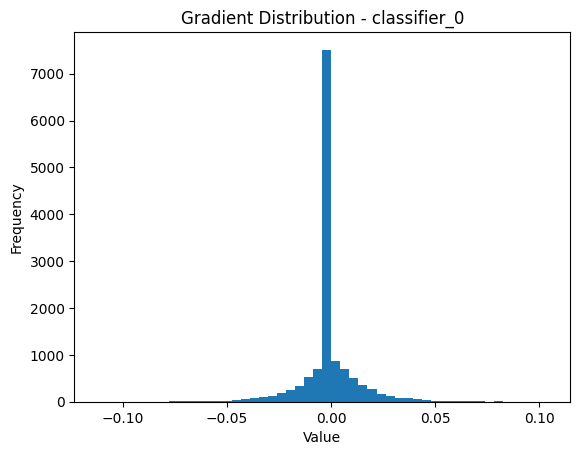

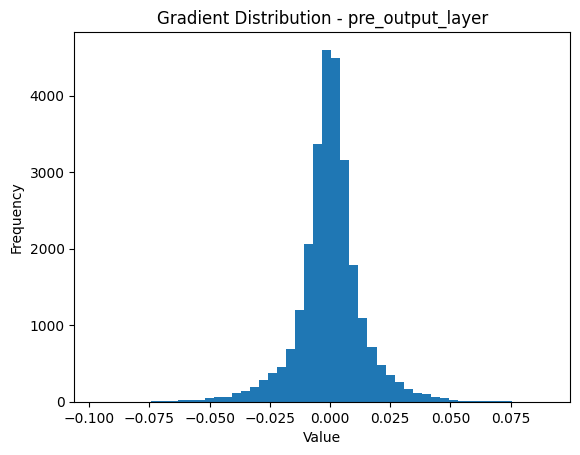

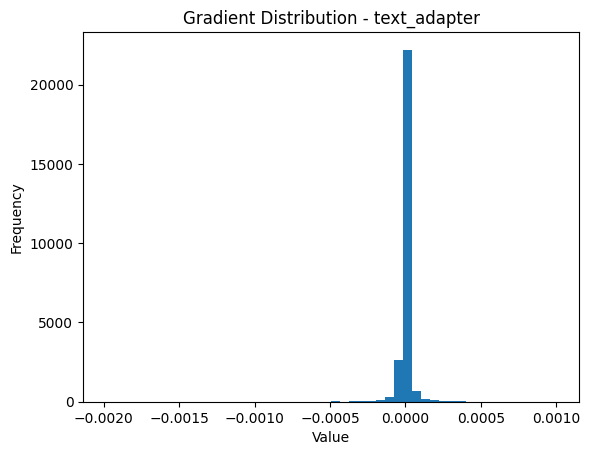

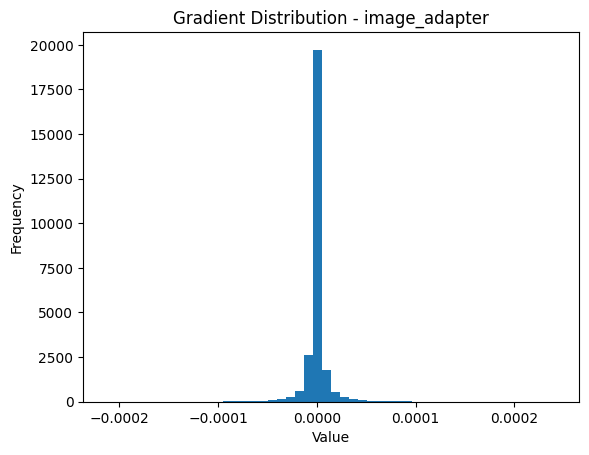

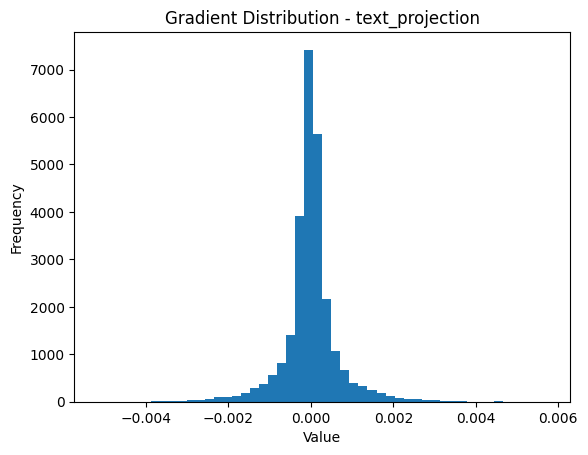

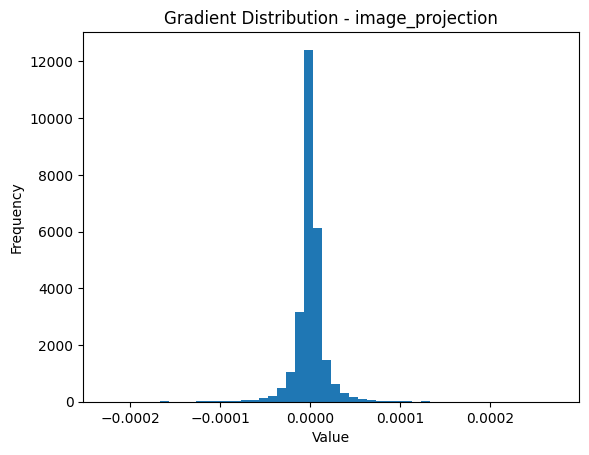

In [42]:
import matplotlib.pyplot as plt

def plot_gradient_distribution(grad, layer_name):
    plt.hist(grad.cpu().numpy().flatten(), bins=50)
    plt.title(f"Gradient Distribution - {layer_name}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

for name, grad in model.gradients.items():
    plot_gradient_distribution(grad, name)